## 1st variant
### Dynamic Bayesian Network Structure Learning with hybrid network = (classic) encoder + (quantum) circuit.
This is a toy example with dummy generated training data of 7 variables, that means 14 vertices (7 for t and 7 for t+1).    
input=(1,14)
n_qubits=2 * ceil(log2(2 * nnodes)) -> for nnodes = 7, n_qubits = 8    
where first four digits correspond to vertice where the edge begins and four last digits correspond to vertice where edge ends i.e. 00100101 corresponds to: vertice_2 ---> vertice_5  
It was tested with two sets of test data at the end of the notebook. The last test is with real data


In [1]:
import pandas as pd
from torch.utils.data import Dataset
import torch
import torchvision
from torch import nn
import numpy as np
import pennylane as qml
import random
import networkx as nx
from matplotlib import pyplot as plt

In [40]:
path = "smaller_elu.csv"

In [41]:
ds = pd.read_csv(path)
ds

,NAME,T,GENE,t0,t1
0,YER111C,0,SWI4,0.32,0.04
1,YBL008W,0,HIR1,0.38,-0.08
2,YNL068C,0,FKH2,-0.29,0.05
3,YLR103C,0,CDC45,0.59,0.77
4,YDR310C,0,SUM1,-0.09,-0.03
...,...,...,...,...,...
58,YDR310C,8,SUM1,0.25,0.23
59,YLR229C,8,CDC42,0.33,0.04
60,YNL068C,8,FKH2,0.48,0.11
61,YDR146C,8,SWI5,0.61,0.29


In [42]:
ds['t0'] = ds.apply(lambda x: x.t1 if pd.isna(x.t0) else x.t0, axis = 1)
ds['t1'] = ds.apply(lambda x: x.t0 if pd.isna(x.t1) else x.t1, axis = 1)

In [43]:
ds[ds['t0'].isnull()]

,NAME,T,GENE,t0,t1


In [44]:
ds[ds['t1'].isnull()]

,NAME,T,GENE,t0,t1


In [ ]:
nnodes = 7
ds = ds.sort_values(by=['T', 'NAME'])
t01_list = [ds[['t0','t1']].iloc[f*nnodes:(f+1)*nnodes].values.T for f in range(len(ds)//nnodes)]
dst = pd.DataFrame({'T':range(len(ds)//nnodes), 't01':t01_list})
dst
nodes_names = {f:ds[['NAME']].iloc[0:nnodes].values[f][0] for f in range(nnodes)}
nodes_genes = {f:ds[['GENE']].iloc[0:nnodes].values[f][0] for f in range(nnodes)}

In [4]:
scale = np.frompyfunc(lambda x, min, max: (x-min)/(max - min), 3, 1)

def get_edges(n=4):
    num_edges = random.randint(n, n+3)
    e1 = [(random.randint(0, n-1),random.randint(0, (n*2)-1)) for f in range(num_edges//2)]
    e2 = [(random.randint(0, (n*2)-1),random.randint(n, (n*2)-1)) for f in range(num_edges//2)]
    return e1 + e2

def get_t0(edges, weights, n=4):
    t0 = np.zeros(n) + 0.01
    edges0 = [edge for i in range(n) for edge in edges if edge[0] == i and edge[1] < n]
    if len(edges0) > 0:
        t0[edges0[0][0]] = random.random()
        for edge in edges0:
            t0[edge[1]] += weights[edge[0]] + weights[edge[1]] * t0[edge[0]]
    return t0
        
def get_t1(edges, weights, t0, n=4):
    t1 = np.zeros(n) + 0.01
    edges1 = [edge for edge in edges if edge[1] >= n]
    for edge in edges1:
        if edge[0] < n:
            t1[edge[1]-n] += weights[edge[0]] + weights[edge[1]-n] * t0[edge[0]]
        else:
            t1[edge[1]-n] += weights[edge[0]-n] + weights[edge[1]-n] * t1[edge[0]-n]
    return t1

In [5]:
# generate training dataset
exper = 1000
n_qubits = 8
arr_list = []
edges_list = []
for f in range(exper):
    weights = [random.randint(1, 10)/10 for f in range(nnodes)]
    edges = get_edges(n = nnodes)
    t0 = get_t0(edges, weights, n = nnodes)
    t1 = get_t1(edges, weights, t0, n = nnodes)
    arr_list.append(scale(np.stack([t0,t1]),np.min(np.stack([t0,t1])), np.max(np.stack([t0,t1]))).astype(float))
    edges_list.append(edges)
arr = np.concatenate(arr_list, axis=1)

In [6]:
dsa = pd.DataFrame({'t01':arr_list})
dsa

,t01
0,"[[0.0, 0.0, 0.44642497351592586, 0.0], [0.0, 0..."
1,"[[0.15974199112048665, 0.0, 0.0, 0.95742322252..."
2,"[[0.40794278644235415, 0.0, 0.0854039600410711..."
3,"[[0.4841977144410114, 0.0, 0.3151975656715449,..."
4,"[[1.0, 0.711241068116992, 0.0, 0.0], [0.434618..."
...,...
995,"[[0.0, 0.6429950836041315, 0.47288936949244004..."
996,"[[0.3089577294550258, 0.520814996503151, 0.0, ..."
997,"[[0.3685513077981199, 0.0, 0.0, 1.0], [0.0, 0...."
998,"[[0.7116410136035412, 0.6136787804158638, 0.0,..."


In [7]:
#int("110100010",2) = 418
edges_bin_list = [[np.binary_repr(ed[0], width=n_qubits//2) + np.binary_repr(ed[1], width=n_qubits//2)  for ed in edges] for edges in edges_list]
ya_list = [[int(edge,2) for edge in edges] for edges in edges_bin_list]

In [8]:
dsa['y'] = ya_list

In [9]:
dsa

,t01,y
0,"[[0.0, 0.0, 0.44642497351592586, 0.0], [0.0, 0...","[18, 5, 7, 23, 62, 62]"
1,"[[0.15974199112048665, 0.0, 0.0, 0.95742322252...","[3, 11, 13, 21, 21, 62]"
2,"[[0.40794278644235415, 0.0, 0.0854039600410711...","[12, 16, 21, 62]"
3,"[[0.4841977144410114, 0.0, 0.3151975656715449,...","[4, 2, 11, 44, 6, 44]"
4,"[[1.0, 0.711241068116992, 0.0, 0.0], [0.434618...","[1, 8, 44, 20]"
...,...,...
995,"[[0.0, 0.6429950836041315, 0.47288936949244004...","[12, 20, 10, 13, 52, 54]"
996,"[[0.3089577294550258, 0.520814996503151, 0.0, ...","[11, 7, 1, 63, 44, 14]"
997,"[[0.3685513077981199, 0.0, 0.0, 1.0], [0.0, 0....","[11, 3, 29, 15]"
998,"[[0.7116410136035412, 0.6136787804158638, 0.0,...","[24, 1, 29, 45]"


In [10]:
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights[0], wires=range(n_qubits), rotation=qml.RX)
    qml.BasicEntanglerLayers(weights[1], wires=range(n_qubits), rotation=qml.RY)
    qml.BasicEntanglerLayers(weights[2], wires=range(n_qubits), rotation=qml.RZ)
    return qml.probs(wires=range(n_qubits))

In [11]:
n_layers = 2
weight_shapes = {"weights": (3, n_layers, n_qubits)}

In [12]:
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

In [13]:
input_size = nnodes * 2
hidden_size = input_size - 2
code_size = n_qubits
encoder_hidden_layer = nn.Linear(
            in_features=input_size, out_features=hidden_size
        )
encoder_output_layer = nn.Linear(
            in_features=hidden_size, out_features=code_size
        )

In [14]:
layers = [encoder_hidden_layer, encoder_output_layer, qlayer]
model = torch.nn.Sequential(*layers)

In [15]:
#optimizer = torch.optim.SGD(model.parameters(), lr=0.2)
#criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [16]:
def error(predictions, y):
    error = np.sum(abs(y.detach().numpy() - predictions.detach().numpy()))/len(y[0].detach().numpy())
    return error

In [17]:
def get_ranks(outputs, y, weighted = False):
    rp = np.flip(np.argsort(outputs.detach().numpy()))
    if weighted:
        a = [np.argwhere(rp == x)[0][1]*outputs.detach().numpy()[0][x]*len(np.nonzero(y.detach().numpy())[1]) for x in np.nonzero(y.detach().numpy())[1]]
    else:
        a = [np.argwhere(rp == x)[0][1] for x in np.nonzero(y.detach().numpy())[1]]
    return a

def score(outputs, y, weighted = False):
    ly = len(np.nonzero(y.detach().numpy())[1])
    lo = len(y[0].detach().numpy())
    ranks = get_ranks(outputs, y, weighted)
    sr = sum(ranks)
    sy = sum(range(ly))
    sw = sum(range(lo-ly,lo))
    return 1 - (sr - sy)/(sw - sy) 

In [18]:
class CustomDataset(Dataset):
    def __init__(self, ds, n, q, transform=None):
        self.ds_full = ds
        self.n = n
        self.q = q
        self.x_csv = self.ds_full[["t01"]]
        self.y_csv = self.ds_full[["y"]]
        self.transform = transform

    def __len__(self):
        return len(self.x_csv)

    def __getitem__(self, idx):
        x = np.array(self.x_csv.iloc[idx].tolist()[0])
        y = np.zeros(2**self.q)
        for i in self.y_csv.iloc[idx].tolist()[0]:
            #011000 24
            y[i] = 1/len(self.y_csv.iloc[idx].tolist()[0])
        if self.transform:
            x = self.transform(x)
            y = self.transform(y)
        return x, y

In [19]:
batch_size = 1
transform = torchvision.transforms.Lambda(lambda y: torch.from_numpy(y).float())

train_dataset = CustomDataset(dsa, nnodes, n_qubits, transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=False
)

In [20]:
%%time
epochs = 1
for epoch in range(epochs):
    loss = 0
    err = 0
    metr = 0
    wmetr = 0
    for batch_features, y_batch in train_loader:
        batch_features = batch_features.view(-1, input_size)
        
        optimizer.zero_grad()
        
        outputs = model(batch_features)
        
        train_loss = criterion(outputs, y_batch)
        
        train_loss.backward()
        
        optimizer.step()
        
        loss += train_loss.item()
    
        err += error(outputs, y_batch)

        metr += score(outputs, y_batch, False)

        wmetr += score(outputs, y_batch, True)

    loss = loss / len(train_loader)

    err = err / len(train_loader)
    
    metr = metr / len(train_loader)

    wmetr = wmetr / len(train_loader)

    print("epoch : {}/{}, loss = {:.6f}, error = {:.6f}, score = {:.6f}, weighted_score = {:.6f}".format(epoch + 1, 
                                                                                                        epochs, 
                                                                                                        loss, 
                                                                                                        err, 
                                                                                                        metr,
                                                                                                        wmetr))

/home/common_user/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:154: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ../aten/src/ATen/native/Copy.cpp:244.)
  Variable._execution_engine.run_backward(


epoch : 1/1, loss = 0.003042, error = 0.028115, score = 0.466001, weighted_score = 1.013632
CPU times: user 1min 20s, sys: 24.4 ms, total: 1min 20s
Wall time: 35.7 s


## testing with generated data

In [21]:
# generate Testing dataset
exper = 12
num_res = 12
arr_list = []
edges_list = []
edges = get_edges(n = nnodes)
for f in range(exper):
    weights = [random.randint(1, 10)/10 for f in range(nnodes)]
    t0 = get_t0(edges, weights, n = nnodes)
    t1 = get_t1(edges, weights, t0, n = nnodes)
    arr_list.append(scale(np.stack([t0,t1]),np.min(np.stack([t0,t1])), np.max(np.stack([t0,t1]))).astype(float))
    edges_list.append(edges)
arr = np.concatenate(arr_list, axis=1)

In [22]:
dstest = pd.DataFrame({'t01':arr_list})
dstest

,t01
0,"[[0.6431575216701528, 0.052490253632743795, 0...."
1,"[[0.7390719952168676, 0.10842613043727307, 0.0..."
2,"[[0.421863613014313, 0.0, 0.001267174267697431..."
3,"[[0.6547462052924197, 0.19859826010788545, 0.0..."
4,"[[0.37838160710082913, 0.12661517585870838, 0...."
5,"[[1.0, 0.4424872179569904, 0.0, 0.0], [0.5, 0...."
6,"[[0.6301150428578723, 0.5238698405735185, 0.0,..."
7,"[[0.5654542694006977, 0.0648907196569223, 0.0,..."
8,"[[0.566541163570909, 0.05948190434611036, 0.0,..."
9,"[[0.723294788528636, 0.08902292489081969, 0.0,..."


In [23]:
#int("110100010",2) = 418
edges_bin_list = [[np.binary_repr(ed[0], width=n_qubits//2) + np.binary_repr(ed[1], width=n_qubits//2)  for ed in edges] for edges in edges_list]
ya_list = [[int(edge,2) for edge in edges] for edges in edges_bin_list]

In [24]:
dstest['y'] = ya_list
dstest

,t01,y
0,"[[0.6431575216701528, 0.052490253632743795, 0....","[8, 8, 12, 37, 61, 13]"
1,"[[0.7390719952168676, 0.10842613043727307, 0.0...","[8, 8, 12, 37, 61, 13]"
2,"[[0.421863613014313, 0.0, 0.001267174267697431...","[8, 8, 12, 37, 61, 13]"
3,"[[0.6547462052924197, 0.19859826010788545, 0.0...","[8, 8, 12, 37, 61, 13]"
4,"[[0.37838160710082913, 0.12661517585870838, 0....","[8, 8, 12, 37, 61, 13]"
5,"[[1.0, 0.4424872179569904, 0.0, 0.0], [0.5, 0....","[8, 8, 12, 37, 61, 13]"
6,"[[0.6301150428578723, 0.5238698405735185, 0.0,...","[8, 8, 12, 37, 61, 13]"
7,"[[0.5654542694006977, 0.0648907196569223, 0.0,...","[8, 8, 12, 37, 61, 13]"
8,"[[0.566541163570909, 0.05948190434611036, 0.0,...","[8, 8, 12, 37, 61, 13]"
9,"[[0.723294788528636, 0.08902292489081969, 0.0,...","[8, 8, 12, 37, 61, 13]"


In [25]:
batch_size = 1
transform = torchvision.transforms.Lambda(lambda y: torch.from_numpy(y).float())

test_dataset = CustomDataset(dstest, nnodes, n_qubits, transform)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True
)


In [26]:
experiments = []
outputs_list = []
for batch_features, _ in test_loader:
    batch_features = batch_features.view(-1, input_size)
    batch_features
    outputs = model(batch_features)
    outputs_list.append(outputs)
    experiments.append(np.flip(np.argsort(outputs.detach().numpy())))
experiments

[array([[15, 30, 12,  2,  1, 54, 23, 36, 46, 50, 42, 20, 49, 35, 33, 62,
         40, 63, 24, 59, 58, 10, 52, 60, 61, 28, 32,  3, 45,  0, 56, 53,
         34, 29, 25, 11, 57, 48, 14, 21, 18, 55, 16, 19,  4,  9, 26, 38,
         37, 43, 41,  6, 39, 17, 47,  8,  5, 44, 31, 51, 13, 22, 27,  7]]),
 array([[15, 30,  2, 12,  1, 54, 36, 23, 46, 50, 42, 49, 20, 33, 35, 62,
         40, 63, 24, 59, 58, 10, 52, 28, 60, 61, 32,  3, 45,  0, 56, 53,
         29, 34, 11, 25, 57, 48, 14, 21, 18, 16, 55, 19,  4,  9, 37, 38,
         26, 43, 41,  6, 39, 47, 17,  8,  5, 31, 44, 13, 51, 22, 27,  7]]),
 array([[15, 12, 30,  2,  1, 54, 23, 36, 46, 50, 42, 20, 49, 35, 33, 62,
         40, 63, 24, 59, 58, 52, 10, 61, 60, 32, 28,  3, 45,  0, 34, 25,
         53, 56, 29, 11, 57, 21, 14, 48, 55, 18, 19, 16,  4,  9, 26, 38,
         37, 41, 43,  6, 17, 39,  8,  5, 47, 44, 51, 13, 31, 22, 27,  7]]),
 array([[15, 30, 12,  2,  1, 54, 36, 23, 46, 42, 50, 20, 49, 33, 62, 35,
         40, 63, 24, 59, 58, 10, 52, 61, 3

In [27]:
ol = [o.detach().numpy() for o in outputs_list]

In [28]:
results_list = np.mean(np.array(ol), axis=0)
norm_results_list = scale(results_list, np.min(results_list), np.max(results_list)).astype(float)
results = np.flip(np.argsort(results_list))

In [29]:
np.max(sum(outputs_list).detach().numpy()),np.min(sum(outputs_list).detach().numpy())

(0.6886959, 0.008357874)

In [30]:
results_bin = [np.binary_repr(f, width=n_qubits) for f in results.tolist()[0]]

In [31]:
results_weights = [norm_results_list[0][results[0][i]] for i in range(len(results[0]))]

In [32]:
results.tolist()[0][:num_res], ya_list[0]

([15, 30, 12, 2, 1, 54, 36, 23, 46, 42, 50, 20], [8, 8, 12, 37, 61, 13])

In [33]:
results_bin[:num_res]

['001111',
 '011110',
 '001100',
 '000010',
 '000001',
 '110110',
 '100100',
 '010111',
 '101110',
 '101010',
 '110010',
 '010100']

In [ ]:
#number of parameters
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
sum([np.prod(p.size()) for p in model_parameters])

In [34]:
def get_edges_array(n_qubits,y):
    arr = [np.binary_repr(f, width=n_qubits) for f in y]
    return [(int(f[:n_qubits//2],2), int(f[n_qubits//2:],2)) for f in arr]

In [35]:
y_edges = get_edges_array(n_qubits,ya_list[0]) 
p_edges = get_edges_array(n_qubits,results.tolist()[0][:num_res]) 
p_weights = results_weights[:num_res]

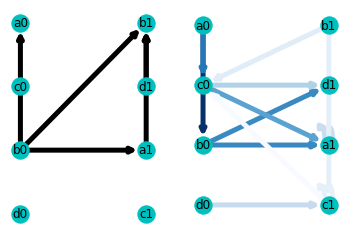

In [36]:
graph_y = None
graph_p = None

graph_y = nx.DiGraph()
graph_p = nx.DiGraph()

graph_y.add_nodes_from(range(nnodes*2))
graph_p.add_nodes_from(range(nnodes*2))

graph_y.add_edges_from(y_edges)
graph_p.add_edges_from(p_edges)

mapping = {0: "a0", 1: "b0", 2: "c0", 3: "d0", 4: "e0", 5: "f0", 6: "g0", 7: "a1", 8: "b1", 9: "c1", 
           10: "d1", 11: "e1", 12: "f1", 13: "g1"}

graph_y = nx.relabel_nodes(graph_y, mapping, copy=False)
graph_p = nx.relabel_nodes(graph_p, mapping, copy=False)

#pos = nx.shell_layout(graph_y, nlist=[range(nnodes),range(nnodes,nnodes*2)], rotate=0.1, center=(1,5))
pos = nx.bipartite_layout(graph_y, nodes=['a0','b0','c0','d0', 'e0', 'f0', 'g0'])

subax1 = plt.subplot(121)
nx.draw(graph_y, pos, node_color='c', edge_color='k', width=5.0, edge_cmap=plt.cm.Blues, with_labels=True)

subax2 = plt.subplot(122)
nx.draw(graph_p, pos, node_color='c', edge_color=p_weights, width=5.0, edge_cmap=plt.cm.Blues, with_labels=True)
plt.show()

## testing with real data

In [ ]:
batch_size = 1
transform = torchvision.transforms.Lambda(lambda y: torch.from_numpy(y).float())

test_dataset = CustomDataset(dst, nnodes, n_qubits, transform)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True
)


In [ ]:
experiments = []
outputs_list = []
for batch_features, _ in test_loader:
    batch_features = batch_features.view(-1, input_size)
    batch_features
    outputs = model(batch_features)
    outputs_list.append(outputs)
    experiments.append(np.flip(np.argsort(outputs.detach().numpy())))
experiments

In [ ]:
ol = [o.detach().numpy() for o in outputs_list]

In [ ]:
results_list = np.mean(np.array(ol), axis=0)
norm_results_list = scale(results_list, np.min(results_list), np.max(results_list)).astype(float)
results = np.flip(np.argsort(results_list))

In [ ]:
np.max(sum(outputs_list).detach().numpy()),np.min(sum(outputs_list).detach().numpy())

In [ ]:
results_bin = [np.binary_repr(f, width=n_qubits) for f in results.tolist()[0]]

In [ ]:
results_weights = [norm_results_list[0][results[0][i]] for i in range(len(results[0]))]

In [ ]:
results.tolist()[0][:num_res]

In [ ]:
results_bin[:num_res]

In [ ]:
p_edges = get_edges_array(n_qubits,results.tolist()[0][:num_res]) 
p_weights = results_weights[:num_res]

In [ ]:
graph_p = None
graph_p2 = None

graph_p = nx.DiGraph()
graph_p2 = nx.DiGraph()

graph_p.add_nodes_from(range(nnodes*2))
graph_p2.add_nodes_from(range(nnodes*2))

graph_p.add_edges_from(p_edges)
graph_p2.add_edges_from(p_edges)

rnodes = [v + '_t0' for _, v in nodes_names.items()]
rgenes = [v + '_t0' for _, v in genes_names.items()]

nodes_names.update({k:v + '_t0' for k, v in nodes_names.items()})
nodes_names.update({k + len(nodes_names):v[:-1] + '1' for k, v in nodes_names.items()})

genes_names.update({k:v + '_t0' for k, v in genes_names.items()})
genes_names.update({k + len(genes_names):v[:-1] + '1' for k, v in genes_names.items()})

graph_p = nx.relabel_nodes(graph_p, nodes_names, copy=False)
graph_p2 = nx.relabel_nodes(graph_p2, genes_names, copy=False)

#pos = nx.shell_layout(graph_y, nlist=[range(nnodes),range(nnodes,nnodes*2)], rotate=0.1, center=(1,5))
pos = nx.bipartite_layout(graph_p, nodes=rnodes)
pos2 = nx.bipartite_layout(graph_p2, nodes=rgenes)

subax1 = plt.subplot(121)
nx.draw(graph_p, pos, node_color='c', edge_color=p_weights, width=5.0, edge_cmap=plt.cm.Blues, with_labels=True)

subax2 = plt.subplot(122)
nx.draw(graph_p2, pos2, node_color='c', edge_color=p_weights, width=5.0, edge_cmap=plt.cm.Blues, with_labels=True)
plt.show()